In [22]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from utils import LOG_DIR, SPEED_LOG_DIR, GPT_LOG_DIR
from typing import Dict

def parse_log_file(file_path):
    # Define the patterns to search for
    peak_activation_memory_pattern = r"Peak Activation Memory: (.+?) Bytes"
    total_memory_pattern = r"Total Memory: (.+?) Bytes"
    avg_forward_time_pattern = r"Average Forward Time: (.+?) sec"
    avg_backward_time_pattern = r"Average Backward Time: (.+?) sec"
    throughput_pattern = r"Throughput: (.+?) samples/sec"
    max_memory_device_pattern = r"(cuda:\d+): (.+?) Bytes"

    # Dictionary to store the extracted information
    data = {
        "peak_activation_memory_mib": None,
        "peak_activation_memory_gib": None,
        "total_memory_mib": None,
        "total_memory_gb": None,
        "average_forward_time_sec": None,
        "average_backward_time_sec": None,
        "throughput_samples_per_sec": None,
        "max_memory_per_device_mib": {},
        "max_memory_per_device_gib": {},
    }

    def convert_data(data_str):
        return ''.join(str(data_str).split(','))
    
    def bytes_to_mib(bytes_str):
        # Convert bytes to MiB
        bytes_str = convert_data(bytes_str)
        return round(int(bytes_str) / (1024**2), 2)
    
    def bytes_to_gib(bytes_str):
        # Convert bytes to GiB
        bytes_str = convert_data(bytes_str)
        return round(int(bytes_str) / (1024**3), 2)

    with open(file_path, 'r') as file:
        for line in file:
            # Check for each pattern and extract data
            if match := re.search(peak_activation_memory_pattern, line):
                data["peak_activation_memory_mib"] = bytes_to_mib(match.group(1))
                data["peak_activation_memory_gib"] = bytes_to_gib(match.group(1))
            elif match := re.search(total_memory_pattern, line):
                data["total_memory_mib"] = bytes_to_mib(match.group(1))
                data["total_memory_gb"] = bytes_to_gib(match.group(1))
            elif match := re.search(avg_forward_time_pattern, line):
                data["average_forward_time_sec"] = float(match.group(1))
            elif match := re.search(avg_backward_time_pattern, line):
                data["average_backward_time_sec"] = float(match.group(1))
            elif match := re.search(throughput_pattern, line):
                data["throughput_samples_per_sec"] = float(match.group(1))
            elif match := re.search(max_memory_device_pattern, line):
                device, memory_bytes = match.groups()
                data["max_memory_per_device_mib"][device] = bytes_to_mib(memory_bytes)
                data["max_memory_per_device_gib"][device] = bytes_to_gib(memory_bytes)

    return data

def print_dict(data: Dict):
    for key, value in data.items():
        print(f"{key}: {value}")


def args_to_exprname(
    num_partition: int,
    num_microbatch: int,
    checkpoint_enabled: bool,
    use_torchgpipe: bool,
    gpt_2: bool=False,
):
    if not gpt_2:
        if num_partition > 0:
            return (f'mem_expr_K{num_partition}_M{num_microbatch}_'
                f'{"check_" if checkpoint_enabled else ""}'
                f'{"torchgpipe" if use_torchgpipe else "self"}'
            )
        else:
            return 'baseline'
    else:
        if num_partition > 0:
            return (f'gpt2_K{num_partition}_M{num_microbatch}_'
                f'{"check_" if checkpoint_enabled else ""}'
                f'{"torchgpipe" if use_torchgpipe else "self"}'
            )
        else:
            return 'gpt2_baseline'

## Memory Experiments
Variables:
- partition plans
- number of microbatches
- checkpointing enabled

### ResNet

In [6]:
# get all file names under DATA_DIR
expr_data = {}
file_names = os.listdir(LOG_DIR)
for file_name in file_names:
    if file_name.endswith(".log"):
        file_path = os.path.join(LOG_DIR, file_name)
        data = parse_log_file(file_path)
        expr_data[file_name[:-4]] = data

num_partitions = [1, 2, 4]
num_micro_batches = [1, 2, 4, 6, 8, 16, 20, 32, 64]
checkpoint_enabled = [True, False]
use_torchgpipe = [True, False]

#### Baseline

In [7]:
expr_name = args_to_exprname(0, 1, False, False)
baseline = expr_data[expr_name]
print_dict(baseline)

peak_activation_memory_mib: 3242.75
total_memory_mib: 4270.0
average_forward_time_sec: 0.057
average_backward_time_sec: 0.026
throughput_samples_per_sec: 384.831
max_memory_per_device_mib: {'cuda:0': 4270.0}


#### Results from torchgpipe

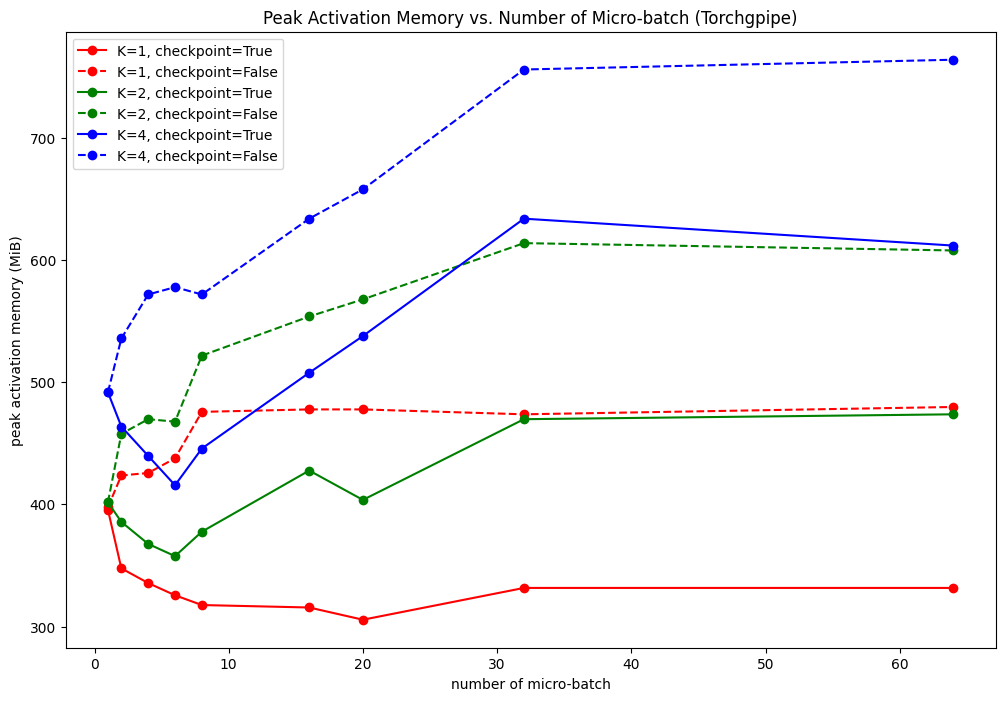

In [8]:
# Data from torch GPipe
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=True
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_mib'])

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (MiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch (Torchgpipe)')
        plt.legend()
plt.show()

#### Results from self-implemented GPipe

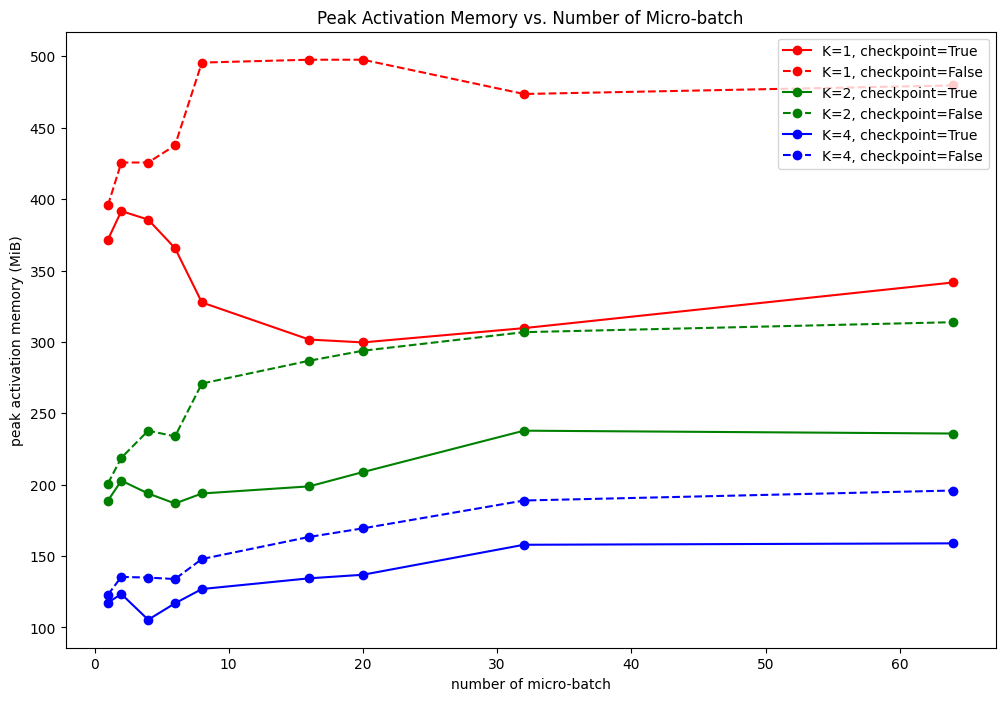

In [10]:
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=False
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_mib'] / num_partition)

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (MiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch')
        plt.legend()
plt.show()

### GPT-2

In [23]:
# get all file names under DATA_DIR
expr_data = {}
file_names = os.listdir(GPT_LOG_DIR)
for file_name in file_names:
    if file_name.endswith(".log"):
        file_path = os.path.join(GPT_LOG_DIR, file_name)
        data = parse_log_file(file_path)
        expr_data[file_name[:-4]] = data

num_partitions = [1, 2, 4]
num_micro_batches = [1, 2, 4, 8, 16, 32, 64]
checkpoint_enabled = [True, False]
use_torchgpipe = [True, False]

#### Baseline

In [25]:
expr_name = args_to_exprname(0, 1, False, False, gpt_2=True)
baseline = expr_data[expr_name]

print(expr_name)
print('-' * 20)
print_dict(baseline)

gpt2_baseline
--------------------
peak_activation_memory_mib: 6614.75
peak_activation_memory_gib: 6.46
total_memory_mib: 7642.0
total_memory_gb: 7.46
average_forward_time_sec: 0.06
average_backward_time_sec: 0.041
throughput_samples_per_sec: 634.796
max_memory_per_device_mib: {'cuda:0': 7642.0}
max_memory_per_device_gib: {'cuda:0': 7.46}


#### Results from torchgpipe

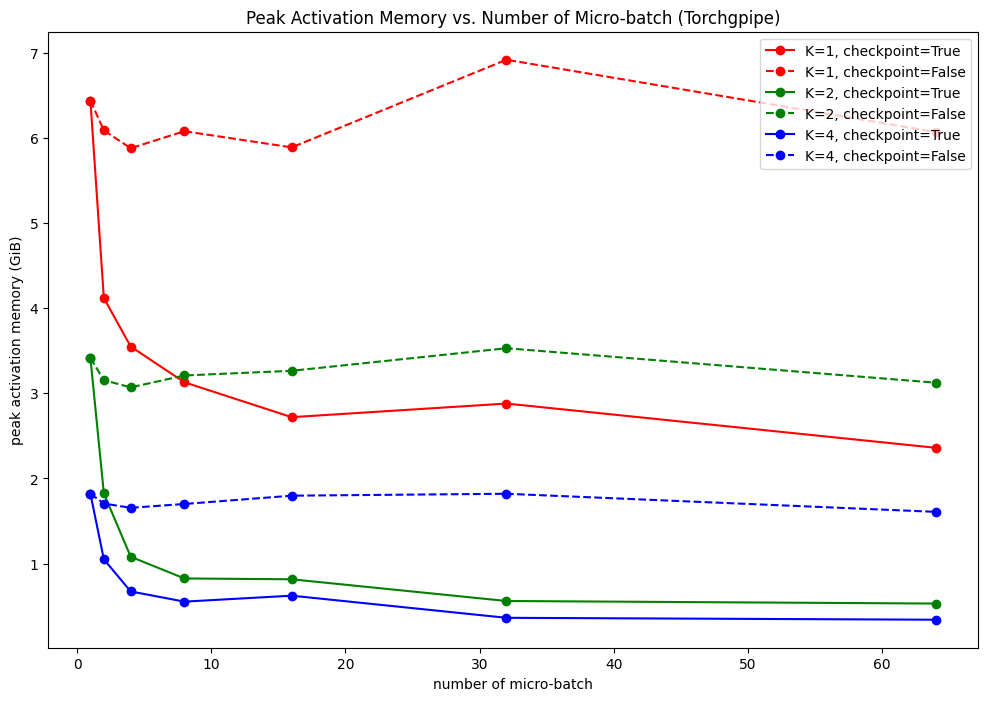

In [27]:
# Data from torch GPipe
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=True, gpt_2=True
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_gib'] / num_partition)

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (GiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch (Torchgpipe)')
        plt.legend()
plt.show()

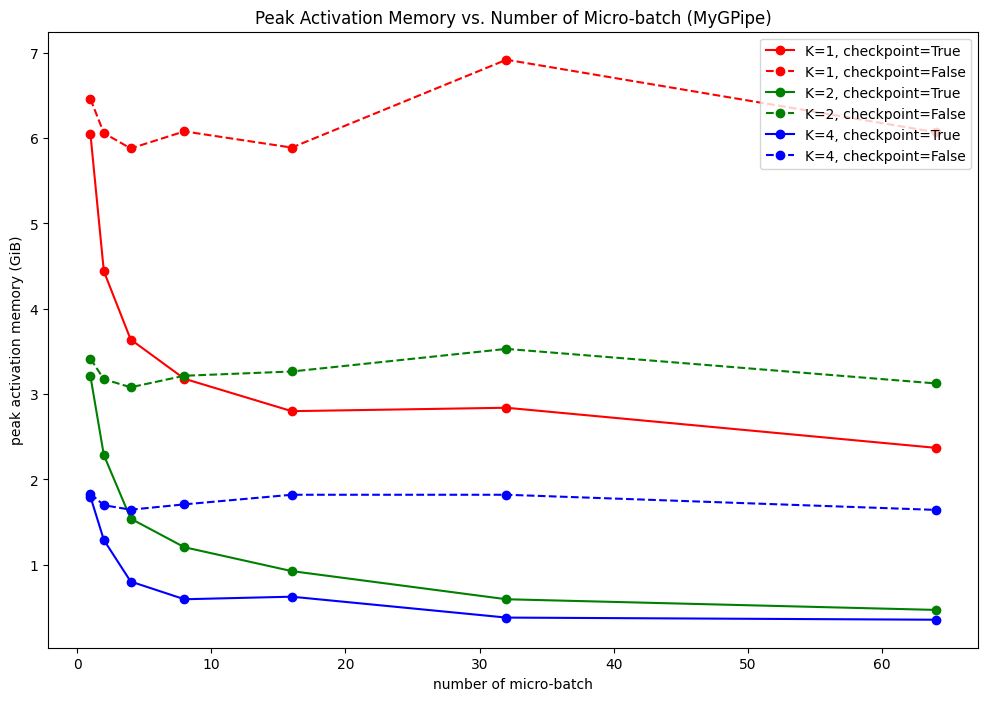

In [29]:
# Data from torch GPipe
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=False, gpt_2=True
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_gib'] / num_partition)

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (GiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch (MyGPipe)')
        plt.legend()
plt.show()

## Efficiency
- fixed: no checkpointing, architecture (`amoebanetd(num_classes=1000,  num_layers=18,  num_filters=256)`), 
- independent variables: number of partitions (n) and number of microbatches (m)
- dependent variables to observe: throughput speed-up rate compared to no parallelism

In [3]:
# get all file names under DATA_DIR
expr_data = {}
file_names = os.listdir(SPEED_LOG_DIR)
for file_name in file_names:
    if file_name.endswith(".log"):
        file_path = os.path.join(SPEED_LOG_DIR, file_name)
        data = parse_log_file(file_path)
        expr_data[file_name[:-4]] = data

In [6]:
def args_to_speed_exprname(num_partitions, num_micro_batches, use_torchgpipe) -> str:
    return \
        f'speed_K{num_partitions}_M{num_micro_batches}_{"torchgpipe" if use_torchgpipe else "self"}'
def args_to_throughput(num_partitions, num_micro_batches, use_torchgpipe) -> float:
    return expr_data[args_to_speed_exprname(num_partitions, num_micro_batches, use_torchgpipe)]['throughput_samples_per_sec']
args_to_throughput(1, 1, False)

2503.309

In [12]:
num_partitions = [1, 2, 4]
num_micro_batches = [1, 4, 32]

import pandas as pd

df = pd.DataFrame(index=[f'M={m}' for m in num_micro_batches], 
                  columns=[f'K={k}' for k in num_partitions],)
baseline_throughput = args_to_throughput(1, 1, False)
for k in num_partitions:
    for m in num_micro_batches:
        df.at[f'M={m}', f'K={k}'] = round(args_to_throughput(k, m, False) / baseline_throughput, 3)
df


,K=1,K=2,K=4
M=1,1.0,1.949,3.414
M=4,1.552,3.393,6.364
M=32,1.468,3.826,10.862
